<a href="https://colab.research.google.com/github/quincyliang/ml-notebooks/blob/master/tensor_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clarifying the cause of tensor exceptions

In [ ]:
import sys

In [ ]:
! pip install -q tensor-sensor

In [ ]:
import tsensor
tsensor.__version__

'0.1b1'

### NumPy

In [ ]:
import numpy as np

W = np.array([[1, 2], [3, 4]])
b = np.array([9, 10]).reshape(2, 1)
x = np.array([4, 5]).reshape(2, 1)
h = np.array([1,2])

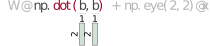

PyTorch says: shapes (2,1) and (2,1) not aligned: 1 (dim 1) != 2 (dim 0)

tsensor adds: Cause: np.dot(b,b) tensor arg b w/shape (2, 1), arg b w/shape (2, 1)


In [ ]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ np.dot(b,b) + np.eye(2,2)@x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### PyTorch

In [ ]:
import tsensor
import torch
import sys

W = torch.tensor([[1, 2], [3, 4]])
b = torch.tensor([9, 10]).reshape(2, 1)
x = torch.tensor([4, 5]).reshape(2, 1)
h = torch.tensor([1,2])

findfont: Font family ['Consolas'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


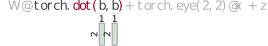

PyTorch says: 1D tensors expected, got 2D, 2D tensors at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:83

tsensor adds: Cause: torch.dot(b,b) tensor arg b w/shape [2, 1], arg b w/shape [2, 1]


In [ ]:
try: # try is used just to catch the exception and extract the messages
    with tsensor.clarify():
        W @ torch.dot(b,b)+ torch.eye(2,2)@x + z
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

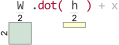

PyTorch says: 1D tensors expected, got 2D, 1D tensors at /tmp/pip-req-build-as628lz5/aten/src/TH/generic/THTensorEvenMoreMath.cpp:83

tsensor adds: Cause: W.dot(h) tensor arg h w/shape [2]


In [ ]:
try:
    with tsensor.clarify():
        W.dot(h) + x
except BaseException as e:
    msgs = e.args[0].split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

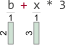

PyTorch says: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 0

tsensor adds: Cause: + on tensor operand b w/shape [2, 1] and operand x*3 w/shape [3, 1]


In [ ]:
x = torch.tensor([4, 5, 6]).reshape(3, 1)

try:
    with tsensor.clarify():
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("PyTorch says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

### TensorFlow

In [ ]:
import tensorflow as tf

In [ ]:
W = tf.constant([[1, 2], [3, 4]])
b = tf.reshape(tf.constant([[9, 10]]), (2, 1))
x = tf.reshape(tf.constant([[8, 5, 7]]), (3, 1))

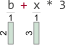

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x*3 w/shape (3, 1)


In [ ]:
try:
    with tsensor.clarify():
        res = x * 3
        res = tf.matmul(W, b)
        b + x * 3
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

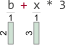

tensorflow says: Incompatible shapes: [2,1] vs. [3,1] [Op:AddV2]

tsensor adds: Cause: + on tensor operand b w/shape (2, 1) and operand x*3 w/shape (3, 1)


In [ ]:
def foo(): bar()
def bar():
    b + x * 3

try:
    with tsensor.clarify(): # works for any called functions too
        foo()
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("tensorflow says: "+msgs[0]+'\n\n')
    sys.stderr.write("tsensor adds: "+msgs[1]+'\n')

## Explaining matrix algebra statements visually

In [ ]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

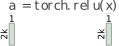

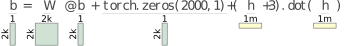

In [ ]:
import tsensor
with tsensor.explain() as explained:
    a = torch.relu(x)
    b = W @ b + torch.zeros(2000,1)+(h+3).dot(h)

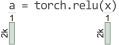

In [ ]:
explained.views[0]

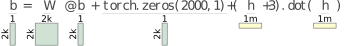

In [ ]:
explained.views[1]

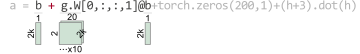

torch says: The size of tensor a (2000) must match the size of tensor b (20) at non-singleton dimension 0

torch adds: Cause: + on tensor operand b w/shape [2000, 1] and operand g.W[0,:,:,1]@b w/shape [20, 1]


In [ ]:
class GRU: # fake random junk
    def __init__(self):
        self.W = torch.rand(size=(2,20,2000,10))
        self.b = torch.rand(size=(20,1))

# W = torch.tensor([[1, 2], [3, 4]])
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,2))

g = GRU()
try:
    with tsensor.explain():
        a = 3
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

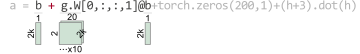

torch says: The size of tensor a (2000) must match the size of tensor b (20) at non-singleton dimension 0

torch adds: Cause: + on tensor operand b w/shape [2000, 1] and operand g.W[0,:,:,1]@b w/shape [20, 1]


In [ ]:
try:
    with tsensor.clarify():
        a = b + g.W[0,:,:,1]@b+torch.zeros(200,1)+(h+3).dot(h)
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

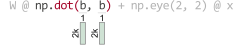

torch says: shapes (2000,1) and (2000,1) not aligned: 1 (dim 1) != 2000 (dim 0)

torch adds: Cause: np.dot(b,b) tensor arg b w/shape [2000, 1], arg b w/shape [2000, 1]


In [ ]:
try:
    with tsensor.clarify():
        W @ np.dot(b, b) + np.eye(2, 2) @ x
except BaseException as e:
    msgs = str(e).split("\n")
    sys.stderr.write("torch says: "+msgs[0]+'\n\n')
    sys.stderr.write("torch adds: "+msgs[1]+'\n')

### Saving explanations to files

In [ ]:
W = torch.rand(size=(2000,2000))
b = torch.rand(size=(2000,1))
h = torch.rand(size=(1_000_000,))
x = torch.rand(size=(2000,1))

with tsensor.explain(savefig="/tmp/foo"): # save foo-1.svg and foo-2.svg in /tmp
    a = torch.relu(x)
    b = W @ b + x * 3 + h.dot(h)

In [ ]:
!ls -l /tmp/foo-?.svg

-rw-r--r-- 1 root root 13799 Oct  7 13:09 /tmp/foo-1.svg
-rw-r--r-- 1 root root 21853 Oct  7 13:09 /tmp/foo-2.svg


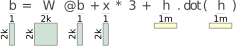

In [ ]:
from IPython.display import SVG
display(SVG("/tmp/foo-2.svg"))

### Lower-level API to show abstract syntax trees (AST) and evaluate them

#### Get ast and computation result

In [ ]:
root, result = tsensor.eval("W @ b + x * 3 + h.dot(h)")  # use current context to evaluate.
result

tensor([[3.3730e+08],
        [3.3544e+08],
        [3.2485e+08],
        ...,
        [3.3222e+08],
        [3.2949e+08],
        [3.3223e+08]])

#### Show the ast

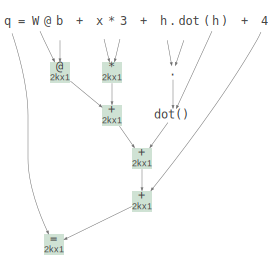

In [ ]:
tsensor.astviz("q = W @ b + x * 3 + h.dot(h) + 4") # don't eval, just show AST

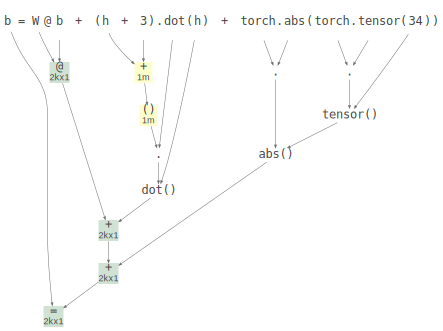

In [ ]:
g = tsensor.astviz("b = W@b + (h+3).dot(h) + torch.abs(torch.tensor(34))", sys._getframe()) # eval, highlight vectors
g

#### Show specific code w/o need of a `with` statement:

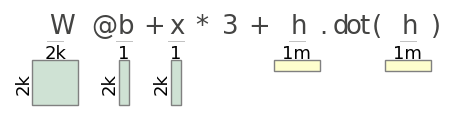

In [ ]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(1,1)
tsensor.pyviz("W @ b + x * 3 + h.dot(h)", ax=ax)
plt.show()

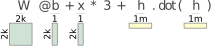

In [ ]:
view = tsensor.pyviz("W @ b + x * 3 + h.dot(h)")
view.show()